# Ethnicity and ONS Covid Deaths

#TODO clean this notebook

In [1]:
import sys
sys.path.insert(0, '../src/data')
import pandas as pd
import geopandas as gpd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import bame_datastore
bame_datastore.lib

Found local clean copy of Local_Authority_Districts__December_2017__Boundaries_in_the_UK__WGS84_
Found local clean copy of fbook_covid_cases
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of excess_deaths_data_grp
Found local clean copy of excess_deaths_data_loc
Found local clean copy of ethnicity_2011
Found local clean copy of furlough_data
Found local clean copy of key_workers
Found local clean copy of deprivation_data
Found local clean copy of population_est_data


{'mortality': ['excess_deaths_grp',
  'excess_deaths_loc',
  'fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers',
  'deprivation',
  'pop_est'],
 'other': ['lad_geog']}

In [35]:
#importing and cleaning our main dataset
excess_deaths_df = bame_datastore.excess_deaths_grp.df # import excess deaths data
ethnicity_df = bame_datastore.ethnicity_data.df # import 2011 census data
ethnicity_list = ethnicity_df.columns[2:] 
df = excess_deaths_df.join(ethnicity_df) # join by local authority

# Adding Population
pop_df = bame_datastore.pop_est.df.copy() # import 2020 population estimates
pop_df = pop_df.reset_index().set_index("Code")
cols_to_sum = pop_df.columns[68:] # gather 65+ columns
pop_df['total_65+'] = pop_df[cols_to_sum].sum(axis=1)  # create 65+ column
pop_df["pct_65+"] = pop_df["total_65+"]/ pop_df["All ages"]
df = df.join(pop_df.drop(columns = pop_df.columns[3:-1])) # drop the rest
df.rename(columns={"All ages": "total_pop"}, inplace=True)

df["excess_deaths_per_thsd"] = (df["allexcess"]/df["total_pop"])*1000 # normalise deaths by population
df = df.drop(columns = ["Geography_name", "Denominator", "Name", "Geography1", "pop"])
df = df.dropna()

In [105]:
target_var = "allexcess"
df

,name,week,deaths.1519,AllCause.20,COVID.20,Other.20,allexcess,excessrate_sum,othexcess_sum,excessrate_mean,...,Other ethnic group,Pakistani,White,White British,White Gypsy or Irish Traveller,White Irish,White Other,total_pop,pct_65+,excess_deaths_per_thsd
code,,,,,,,,,,,,,,,,,,,,,
E06000001,Hartlepool,25,1025.2,600.0,108.0,492.0,35.6,38.180219,-72.4,0.610988,...,0.05,0.32,97.69,96.63,0.04,0.21,0.81,93663.0,0.194292,0.380086
E06000002,Middlesbrough,25,1466.4,967.0,205.0,762.0,166.2,118.253940,-38.8,1.808975,...,0.39,4.92,88.18,86.05,0.06,0.41,1.65,140980.0,0.163839,1.178891
E06000003,Redcar and Cleveland,25,1563.2,929.0,133.0,796.0,64.6,47.250545,-68.4,0.853338,...,0.07,0.22,98.54,97.60,0.06,0.31,0.57,137150.0,0.226278,0.471017
E06000004,Stockton-on-Tees,25,1904.0,1039.0,149.0,890.0,3.2,1.622611,-145.8,0.282728,...,0.16,1.60,94.62,93.40,0.07,0.28,0.86,197348.0,0.184562,0.016215
E06000005,Darlington,25,1147.8,703.0,90.0,613.0,76.4,71.692660,-13.6,1.151655,...,0.14,0.14,96.24,93.69,0.33,0.31,1.91,106803.0,0.205397,0.715336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E09000029,Sutton,25,1482.6,968.0,179.0,789.0,139.2,68.060139,-39.8,1.160116,...,0.75,1.36,78.60,70.92,0.10,1.69,5.88,206349.0,0.153245,0.674585
E09000030,Tower Hamlets,25,1067.2,675.0,188.0,487.0,102.6,32.294109,-85.4,0.593270,...,1.26,0.96,45.19,31.18,0.07,1.52,12.42,324745.0,0.064232,0.315940
E09000031,Waltham Forest,25,1424.0,943.0,248.0,695.0,154.0,55.655945,-94.0,1.124728,...,2.61,10.20,52.20,36.01,0.14,1.53,14.51,276983.0,0.108238,0.555991


In [106]:
def reg_plot(df, cov_death_col, title = False):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in ethnicity_list: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of excess deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}.png")

## Covid Deaths Normalising for Population
Using population estimated for [mid April 2020](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland)



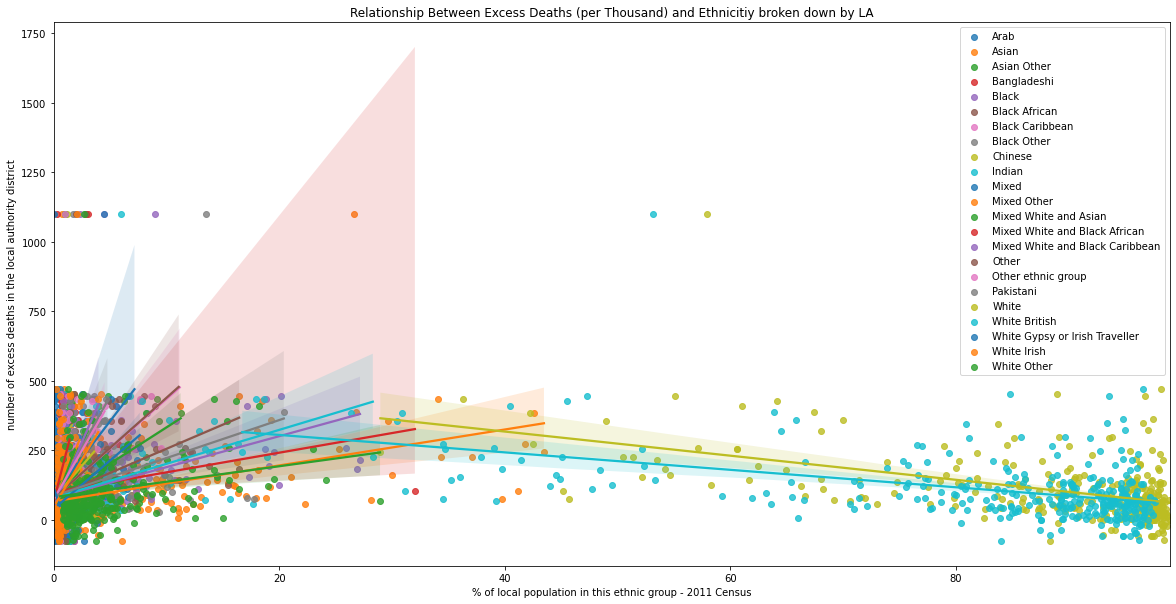

In [107]:
reg_plot(df, target_var, 
         title= "Relationship Between Excess Deaths (per Thousand) and Ethnicitiy broken down by LA")

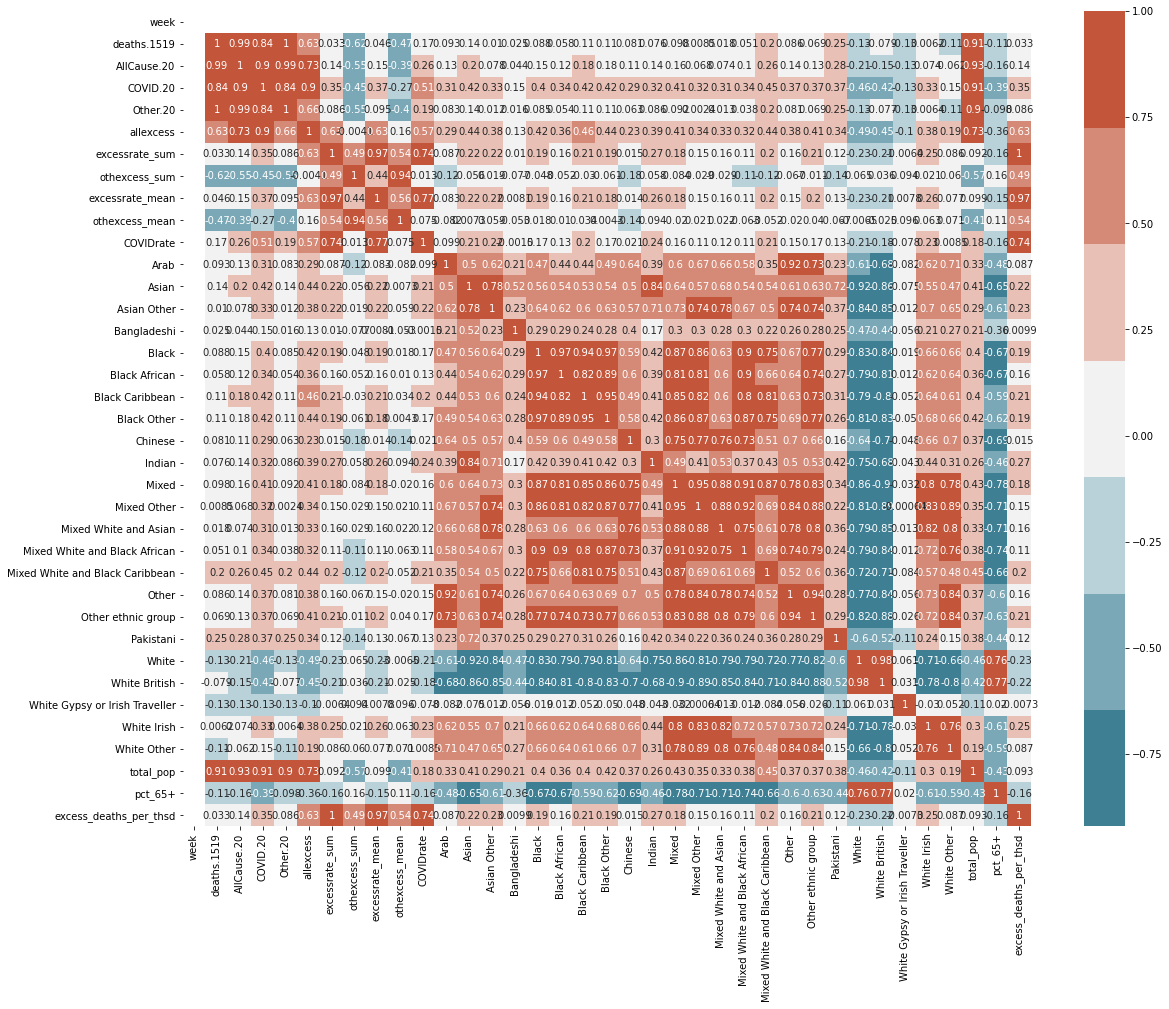

In [108]:
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")

# Grouping Ethnicities
Grouping ethnicities based on the [5 broad ethnic groups](https://www.ethnicity-facts-figures.service.gov.uk/ethnic-groups) used by the goverment. However in doing so we are already losing the heterogeneity wthin these broad categories and may be missing the differing impacts within them.  

In [109]:
df_grouped = df.copy() # target data
df_grouped = df_grouped.drop(columns = ethnicity_list)
# sum groups to get total share
df_grouped["White"] = df[['White', 'White British','White Gypsy or Irish Traveller', 'White Irish', 'White Other']].sum(axis=1)
df_grouped["Mixed"] = df[['Mixed White and Black Caribbean','Mixed White and Asian',
                          'Mixed White and Black African', 'Mixed', 'Mixed Other', ]].sum(axis=1)
df_grouped["Black_African_Caribbean"] = df[['Black', 'Black African', 'Black Caribbean', 'Black Other']].sum(axis=1)
df_grouped["Asian"] = df[['Asian', 'Asian Other', 'Bangladeshi','Chinese','Indian', 'Pakistani', ]].sum(axis=1)
df_grouped["Other"] = df[[ 'Arab','Other', 'Other ethnic group', ]].sum(axis=1)

In [110]:
ethnic_group_cols = df_grouped.columns[15:]
ethnic_group_cols

Index(['White', 'Mixed', 'Black_African_Caribbean', 'Asian', 'Other'], dtype='object')

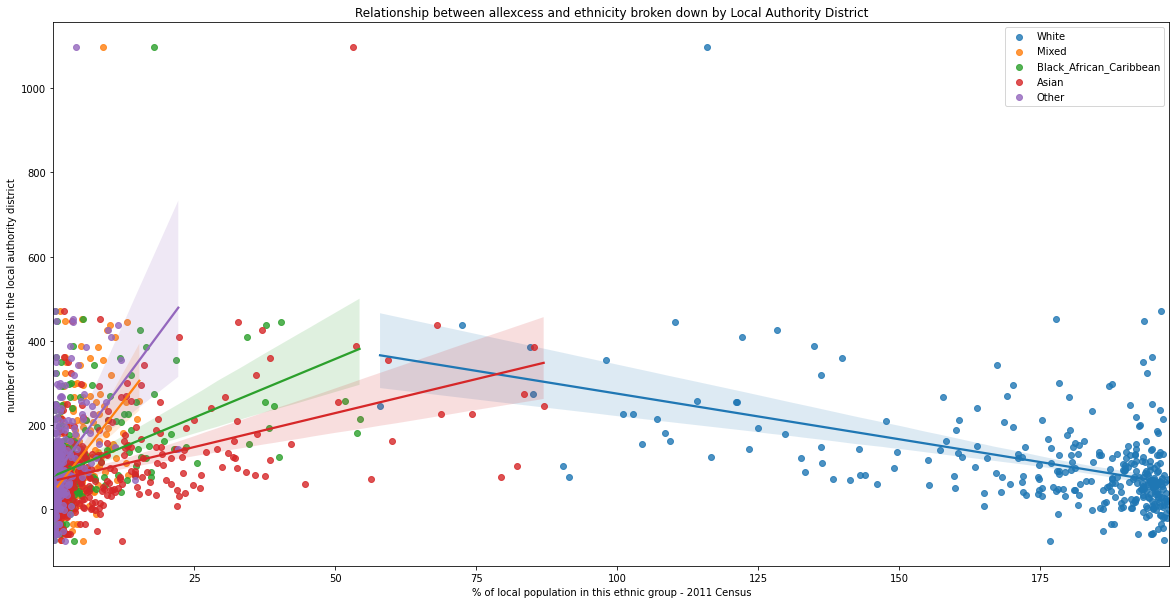

In [111]:
def reg_plot_alt(df, cov_death_col):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in ethnic_group_cols: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}grouped.png")

reg_plot_alt(df_grouped, target_var)


In [112]:
df_grouped.columns

Index(['name', 'week', 'deaths.1519', 'AllCause.20', 'COVID.20', 'Other.20',
       'allexcess', 'excessrate_sum', 'othexcess_sum', 'excessrate_mean',
       'othexcess_mean', 'COVIDrate', 'total_pop', 'pct_65+',
       'excess_deaths_per_thsd', 'White', 'Mixed', 'Black_African_Caribbean',
       'Asian', 'Other'],
      dtype='object')

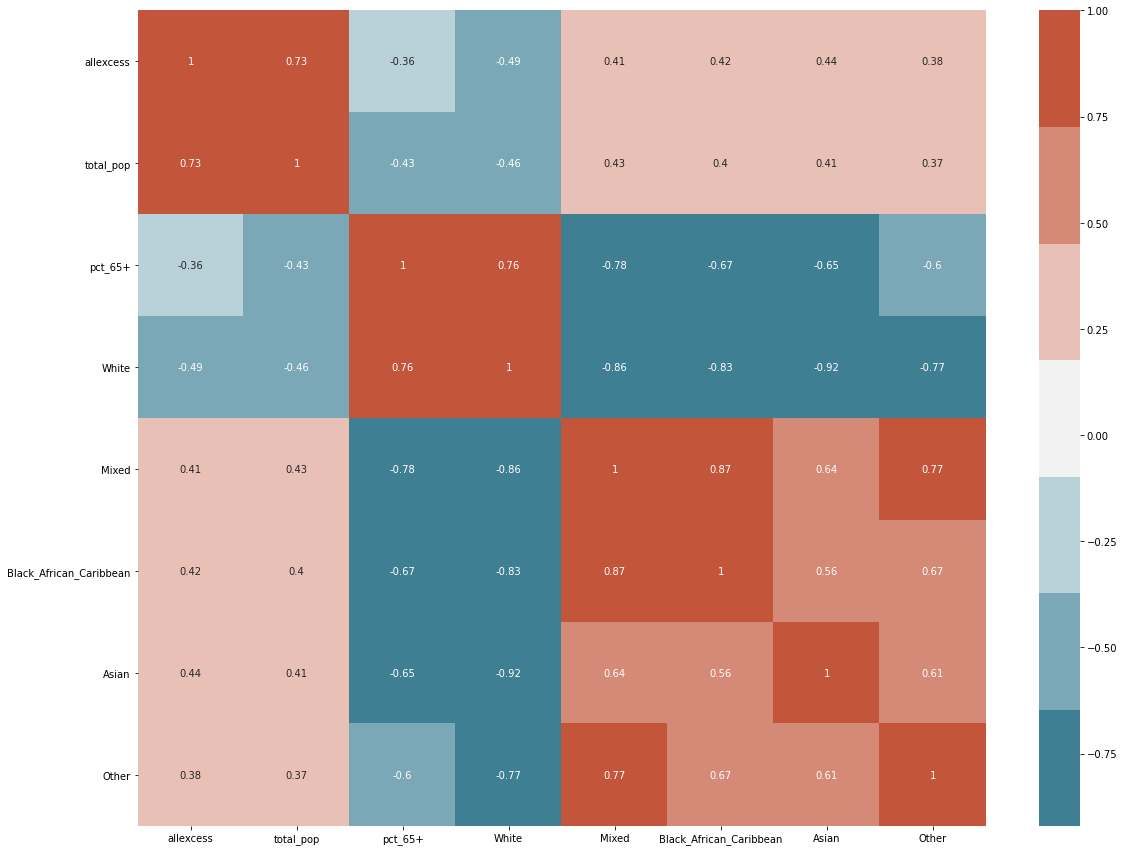

In [120]:
#correlation matrix of relevant variables
df_cor = df_grouped[[target_var, 'total_pop', 'pct_65+',
                     'White', 'Mixed', 'Black_African_Caribbean','Asian', 'Other']]
plt.figure(figsize=(19, 15))
corrMatrix = df_cor.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat_grouped.png")


## Deprivation and Furlough and Density

Calculate population density of local authorities, using the [size of polygons](https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas)
cross refrencing with the [GLA density estimates](https://data.gov.uk/dataset/a76f46f9-c10b-4fe7-82f6-aa928471fcd1/land-area-and-population-density-ward-and-borough).

In [114]:
# Adding Furlough
furlough_df = df_grouped.join(bame_datastore.furlough_data.df.drop(columns="Area Name"))
furlough_df["furloughed_pop"] = furlough_df["total_furloughed"]/ furlough_df["total_pop"]
# furlough_df = furlough_df.drop(columns=['deaths_all', 'deaths_covid', 'total_pop', "total_furloughed"])

In [115]:
# Adding Deprivation measures
deprv_df = bame_datastore.deprivation.df.copy()
deprv_df = deprv_df.drop(columns=['IMD_decile_avg', 'IMD_decile_std', "IMD_rank_std"])
dep_fur_df = furlough_df.join(deprv_df)

In [116]:
# Adding Population Density

la_gdf = bame_datastore.lad_geog.gdf.copy()
la_gdf = la_gdf.to_crs({'init': 'epsg:5243'}) # change projection to get the area 
la_gdf["area"] = la_gdf['geometry'].area/ 10**6 # area in square km

dep_fur_df

dense_df = dep_fur_df.join(la_gdf.set_index("lad17cd"))
dense_df["pop_density"] = dense_df["total_pop"]/dense_df["area"]
dense_df = dense_df.drop(columns=["lad17nm", "bng_n",'objectid', 'lad17nmw', 'bng_e', 
                                  'st_areashape','st_lengthshape',"long","lat"])



/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [117]:
target_var

'allexcess'

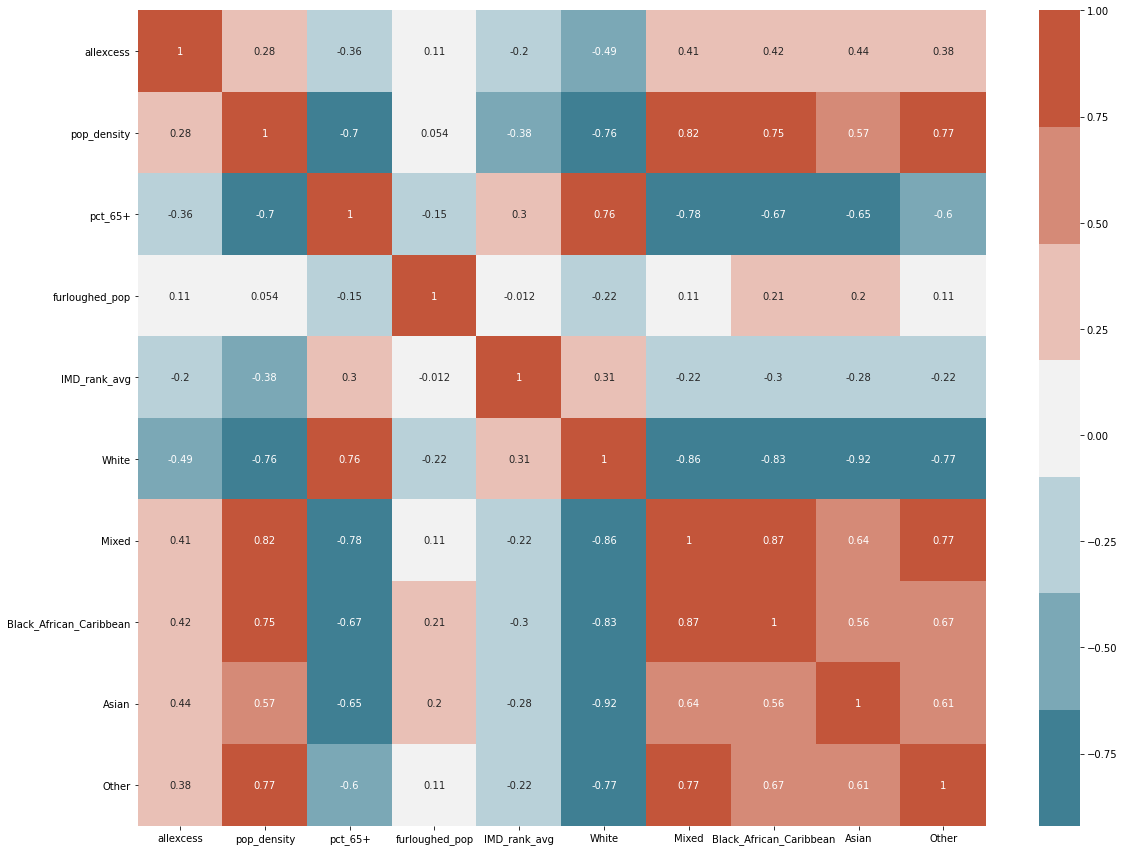

In [118]:
dense_df_plot = dense_df.drop(columns=[ "area", "total_pop", 'total_furloughed', 
                                       'Local Authority District name (2019)','geometry',])


dense_df_plot = dense_df_plot[[target_var,'pop_density','pct_65+','furloughed_pop', 'IMD_rank_avg',
                                'White', 'Mixed','Black_African_Caribbean', 'Asian', 'Other']]

# dense_df_plot.columns = ['Area Name','Covid Deaths pct',
#                                'White', 'Mixed','Black African Caribbean', 'Asian', 'Other', 
#                                'Population Density','pct 65+','pct Furloughed', 'IMD rank avg',  ]


plt.figure(figsize=(19, 15))
corrMatrix = dense_df_plot.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.savefig("../reports/figures/furlough_deprivation_cormat.png")

# Regression
Caution advised

In [126]:
dense_df.to_csv("../data/processed/dense_df.csv")

# Create master df
master_df = dense_df.join(bame_datastore.furlough_data.df.drop(columns="Area Name"))
master_df
master_df = dense_df.join(deprv_df).drop(columns=["Local Authority District name (2019)"])
master_df.to_csv("../data/processed/master_df.csv")


# master_df = master_df.drop(columns=["deaths_all", "deaths_covid", "area", "total_pop"])
plt.figure(figsize=(19, 15))
corrMatrix = master_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))

ValueError: columns overlap but no suffix specified: Index(['Local Authority District name (2019)', 'IMD_rank_avg'], dtype='object')

In [121]:
reg_all = master_df.reset_index().drop(columns=["code", "name", "week", "geometry", 
                                              "AllCause.20", "COVID.20", "Other.20", "allexcess", 
                                               "excessrate_sum","othexcess_sum","excessrate_mean", 
                                              "othexcess_mean", "COVIDrate"])
X = reg_all.drop(columns=[target_var])
y = reg_all[target_var]
res = sm.OLS(y, X.astype(float), missing='drop').fit()

res.summary()



KeyError: "['allexcess'] not found in axis"